# 3.4 ベータ事前分布の混合

In [1]:
import pandas as pd
import numpy as np
from scipy import stats, signal, special
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Markdown
from mylib.plot import contourplot

sns.set_theme()
warnings.simplefilter("ignore")

In [2]:
# 36カ月以内に投獄から解放された人数
n = 43

# 再犯者の人数
y = 15

## a

それぞれの分布は

$$
\begin{aligned}
p(\theta) &= dbeta(\theta, a=2, b=8) \\
p(y|\theta) &= dbinom(y, n, \theta) \\
p(\theta| y) &= dbeta(\theta, a + y, b + n - y) \\
\end{aligned}
$$
である。

In [3]:
def construct_df_3_4(a, b, y, n):
    df_3_4 = pd.DataFrame()

    # 1~0のthetaの値を作成
    n_points = 200
    df_3_4["theta"] = np.linspace(0, 1, n_points)

    # 事前分布
    df_3_4["prior"] = stats.beta.pdf(df_3_4["theta"], a=a, b=b)

    # 尤度
    df_3_4["likelihood"] = stats.binom.pmf(y, n=n, p=df_3_4["theta"])

    # 事後分布
    df_3_4["posterior"] = stats.beta.pdf(df_3_4["theta"], a=(a + y), b=(b + n - y))

    return df_3_4

In [4]:
def plot_3_4(df):
    mosaic = [
        ["prior"],
        ["likelihood"],
        ["posterior"],
    ]
    fig, axes = plt.subplot_mosaic(mosaic, figsize=(6, 5))

    # 事前分布
    axes["prior"].set(title="Prior")
    sns.lineplot(
        df,
        x="theta",
        y="prior",
        ax=axes["prior"],
    )

    # 尤度
    axes["likelihood"].set(title="Likelihood")
    sns.lineplot(
        df,
        x="theta",
        y="likelihood",
        ax=axes["likelihood"],
    )

    # 事後分布
    axes["posterior"].set(title="Posterior")
    sns.lineplot(
        df,
        x="theta",
        y="posterior",
        ax=axes["posterior"],
    )

    fig.tight_layout()

    return fig

In [5]:
def summarise_binom_beta(a, b, y, n, print_results=False):
    # 結果を保存する辞書
    results_dict = {}

    # 事後分布のパラメータ
    a_posterior = a + y
    b_posterior = b + n - y
    results_dict["a_posterior"] = a_posterior
    results_dict["b_posterior"] = b_posterior

    # 事後平均, 事後分散
    posterior_mean, posterior_var = stats.beta.stats(
        a=a_posterior, b=b_posterior, moments="mv"
    )
    results_dict["posterior_mean"] = posterior_mean
    results_dict["posterior_var"] = posterior_var
    results_dict["posterior_std"] = np.sqrt(posterior_var)

    # 事後モード
    posterior_mode = (a_posterior - 1) / (a_posterior + b_posterior - 2)
    results_dict["posterior_mode"] = posterior_mode

    # 信用区間
    credible_interval = stats.beta.interval(
        confidence=0.95, a=a_posterior, b=b_posterior
    )
    results_dict["credible_interval"] = credible_interval

    if print_results:
        print(
            "Posterior Distributiion:\n",
            f"\t beta({a_posterior}, {b_posterior})",
            end="\n",
        )
        print("Posterior Mean:\n", f"\t {posterior_mean}", end="\n")
        print("Posterior Variance:\n", f"\t {posterior_var}", end="\n")
        print("Posterior Mode:\n", f"\t {posterior_mode}", end="\n")
        print("95% Credible Interval:\n", f"\t {credible_interval}", end="\n")

    return results_dict

In [6]:
# 事前分布のパラメータ
a, b = 2, 8

df_3_4_a = construct_df_3_4(a=a, b=b, y=y, n=n)
df_3_4_a.head()

,theta,prior,likelihood,posterior
0,0.000000,0.000000,0.000000e+00,0.000000e+00
1,0.005025,0.349272,4.329615e-24,5.170957e-23
2,0.010050,0.674220,1.231199e-19,2.838488e-18
3,0.015075,0.975937,4.675335e-17,1.560242e-15
4,0.020101,1.255481,3.031747e-15,1.301549e-13


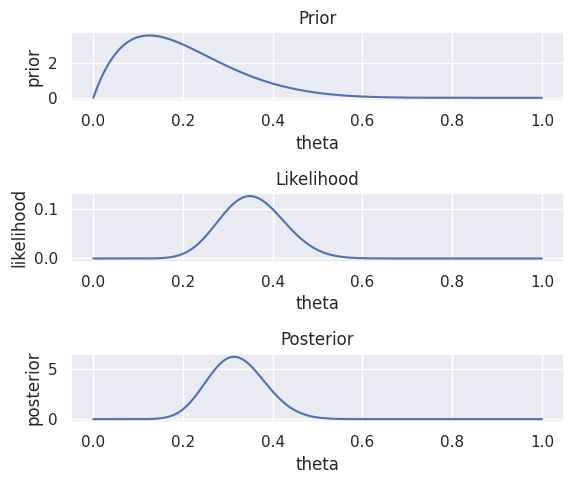

In [7]:
fig = plot_3_4(df_3_4_a)

In [8]:
results_a = summarise_binom_beta(a, b, y, n, print_results=True)

Posterior Distributiion:
 	 beta(17, 36)
Posterior Mean:
 	 0.32075471698113206
Posterior Variance:
 	 0.004034650528064555
Posterior Mode:
 	 0.3137254901960784
95% Credible Interval:
 	 (0.2032977878191033, 0.4510239822166316)


## b

In [9]:
# 事前分布のパラメータ
a, b = 8, 2

df_3_4_b = construct_df_3_4(a=a, b=b, y=y, n=n)
df_3_4_b.head()

,theta,prior,likelihood,posterior
0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,0.005025,5.796597e-15,4.329615e-24,1.866924e-35
2,0.010050,7.382171e-13,1.231199e-19,6.761087e-29
3,0.015075,1.254910e-11,4.675335e-17,4.364452e-25
4,0.020101,9.353248e-11,3.031747e-15,2.109403e-22


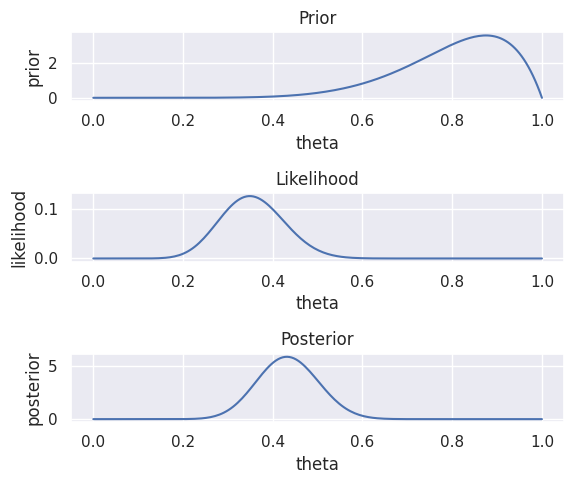

In [10]:
fig = plot_3_4(df_3_4_b)

In [11]:
results_b = summarise_binom_beta(a, b, y, n, print_results=True)

Posterior Distributiion:
 	 beta(23, 30)
Posterior Mean:
 	 0.4339622641509434
Posterior Variance:
 	 0.0045488706934061155
Posterior Mode:
 	 0.43137254901960786
95% Credible Interval:
 	 (0.30469562471174694, 0.567952795996458)


## c

In [12]:
df_3_4_c = df_3_4_a[["theta", "prior"]].copy()
df_3_4_c.rename(columns={"prior": "prior_a"}, inplace=True)

df_3_4_c["prior_b"] = df_3_4_b["prior"]

df_3_4_c["prior_c"] = (3 / 4) * df_3_4_a["prior"] + (1 / 4) * df_3_4_b["prior"]

df_3_4_c.head()

,theta,prior_a,prior_b,prior_c
0,0.000000,0.000000,0.000000e+00,0.000000
1,0.005025,0.349272,5.796597e-15,0.261954
2,0.010050,0.674220,7.382171e-13,0.505665
3,0.015075,0.975937,1.254910e-11,0.731953
4,0.020101,1.255481,9.353248e-11,0.941611


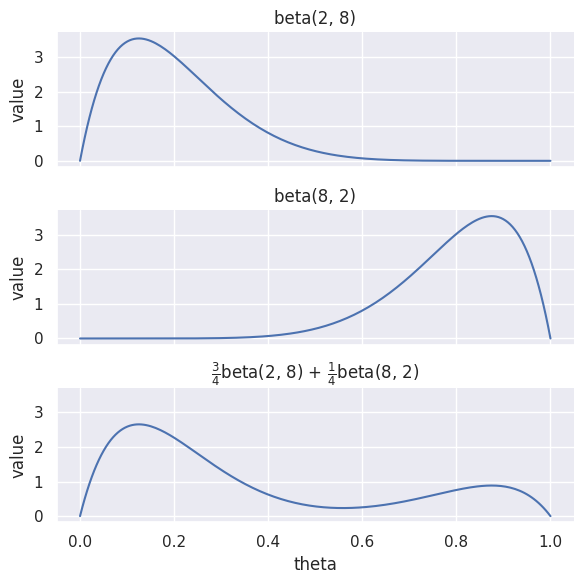

In [13]:
g = sns.relplot(
    df_3_4_c.melt(id_vars="theta"),
    x="theta",
    y="value",
    row="variable",
    kind="line",
    height=2,
    aspect=3,
)
# タイトルを編集
axes = g.axes.ravel()
titles = [
    "beta(2, 8)",
    "beta(8, 2)",
    r"$\frac{3}{4}$beta(2, 8) + $\frac{1}{4}$beta(8, 2)",
]
_ = [ax.set(title=title) for ax, title in zip(axes, titles)]

cの事前分布は $\theta \approx 0.1$ に大きいピークと $\theta \approx 0.9$ に小さいピークを持つ。  
これは、投獄から解放された人が75%ほどの再犯率の低いグループと25%ほどの再犯率の高いグループから構成されるという事前情報を表している。

## d

### i

$$
\begin{aligned}
p(\theta) \times p(y | \theta)
&= \frac{1}{4} 
\frac{\Gamma(10)}{\Gamma(2)\Gamma(8)}
[3\theta(1 - \theta)^{7} + \theta^{7}(1 - \theta)]
\times
\binom{n}{y}
\theta^{y}(1 - \theta)^{n - y}
\\
&= 
\frac{\Gamma(10)}{\Gamma(2)\Gamma(8)}
\binom{n}{y}
\times
\left[
\frac{3}{4} \theta^{y + 1} (1 - \theta)^{n - y + 7}
+ \frac{1}{4} \theta^{y + 7} (1 - \theta)^{n - y + 1}
\right]
\\
&=
\left[
3 \theta^{y + 1} (1 - \theta)^{n - y + 7}
+ \theta^{y + 7} (1 - \theta)^{n - y + 1}
\right] \times const.
\\
&=
\left[
3 \theta^{16} (1 - \theta)^{35}
+ \theta^{22} (1 - \theta)^{29}
\right] \times const.
\end{aligned}
$$


### ii

事後分布は
$ p(\theta | y) \propto p(\theta) \times p(y | \theta) $
であることと、 $\int d\theta ~ p(\theta | y) = 1$ であることから計算できる。

まず、正規化定数を計算する。

$$
\begin{aligned}
1 &= \int d\theta ~ p(\theta | y) \\
&= 
\int d\theta ~ 
\left[
3 \theta^{16} (1 - \theta)^{35}
+ \theta^{22} (1 - \theta)^{29}
\right] \times const.
\\
&=
\left[
 3 B(17, 36) + B(23, 30)
\right] \times const.
\end{aligned}
$$

この計算から

$$
const. = \frac{1}{3 B(17, 36) + B(23, 30)}
$$

となる。

以上の結果から、事後分布は次のようになる。

$$
\begin{aligned}
p(\theta | y) &= 
\frac{1}{3 B(17, 36) + B(23, 30)} 
\left[
3 \theta^{16} (1 - \theta)^{35}
+ \theta^{22} (1 - \theta)^{29}
\right]
\\
&= 
\frac{3 B(17, 36)}{3 B(17, 36) + B(23, 30)} 
\frac{1}{B(17, 36)}
\theta^{16} (1 - \theta)^{35}
\\
&\quad +
\frac{B(23, 30)}{3 B(17, 36) + B(23, 30)} 
\frac{1}{B(23, 30)}
\theta^{22} (1 - \theta)^{29}
\\
&= 
\frac{3 B(17, 36)}{3 B(17, 36) + B(23, 30)} 
\times
dbeta(\theta, 17, 36)
\\
&\quad +
\frac{B(23, 30)}{3 B(17, 36) + B(23, 30)} 
\times
dbeta(\theta, 23, 30)
\end{aligned}
$$


### iii


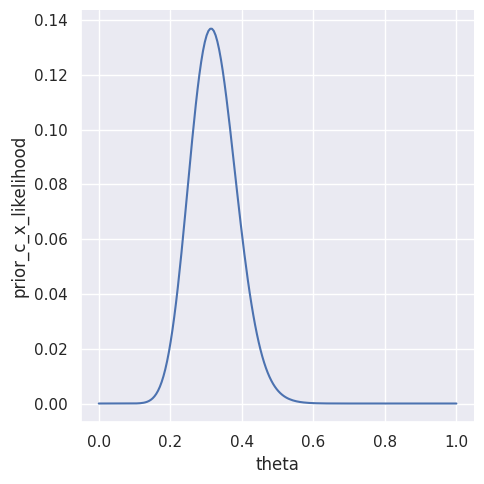

In [14]:
df_3_4_c["prior_c_x_likelihood"] = df_3_4_c["prior_c"] * df_3_4_a["likelihood"]

_ = sns.relplot(
    df_3_4_c,
    x="theta",
    y="prior_c_x_likelihood",
    kind="line",
)

In [15]:
# 事後モード
(ind,) = signal.argrelmax(df_3_4_c["prior_c_x_likelihood"].values)
posterior_mode = df_3_4_c.loc[ind, ["theta", "prior_c_x_likelihood"]].to_dict(
    orient="records"
)[0]
posterior_mode

{'theta': 0.3165829145728643, 'prior_c_x_likelihood': 0.13681439196814513}

In [16]:
def beta_mode(a, b):
    return (a - 1) / (a + b - 2)

In [17]:
results_a["posterior_mode"] = beta_mode(
    results_a["a_posterior"],
    results_a["b_posterior"],
)
results_b["posterior_mode"] = beta_mode(
    results_b["a_posterior"],
    results_b["b_posterior"],
)
print("aの結果")
display(results_a)
print("bの結果")
display(results_b)

aの結果


{'a_posterior': 17,
 'b_posterior': 36,
 'posterior_mean': 0.32075471698113206,
 'posterior_var': 0.004034650528064555,
 'posterior_std': 0.0635188989834093,
 'posterior_mode': 0.3137254901960784,
 'credible_interval': (0.2032977878191033, 0.4510239822166316)}

bの結果


{'a_posterior': 23,
 'b_posterior': 30,
 'posterior_mean': 0.4339622641509434,
 'posterior_var': 0.0045488706934061155,
 'posterior_std': 0.06744531631926798,
 'posterior_mode': 0.43137254901960786,
 'credible_interval': (0.30469562471174694, 0.567952795996458)}

In [23]:
df_3_4_d = pd.DataFrame(
    index=pd.Index(["a", "b", "c"]),
    data={
        "prior": [
            "beta(2, 8)",
            "beta(8, 2)",
            "3/4 beta(2, 8) + 1/4 beta(8, 2)",
        ],
        "posterior_mode": [
            results_a["posterior_mode"],
            results_b["posterior_mode"],
            posterior_mode["theta"],
        ],
    },
)

df_3_4_d

,prior,posterior_mode
a,"beta(2, 8)",0.313725
b,"beta(8, 2)",0.431373
c,"3/4 beta(2, 8) + 1/4 beta(8, 2)",0.316583


上記の結果から事後モードは

$$
a \lesssim c < b
$$

## e

以下の事前分布を考える

$$
\begin{aligned}
p(\theta) 
&= \sum _{i=1}^{k} w_{i} \times dbeta(\theta, a_{i}, b_{i})
\\
& \quad where \quad 
\sum _{i=1}^{k} w_{i} = 1
\end{aligned}
$$

このとき、 d) ii.と同様の計算から事後分布は

$$
\begin{aligned}
p(\theta | y) &= 
\sum _{i=1}^{k}
\tilde{w}_{i}
\times
dbeta(\theta, a_{i} + y, b_{i} + n - y)
\end{aligned}
$$

となる。
ここで、 $\tilde{w}_{i}$ は事後分布の重みで、

$$
\tilde{w}_{i} = 
\frac{w_{i} B(a_{i} + y, b_{i} + n - y) / B(a_{i}, b_{i})}{\sum_{j=1}^{k} w_{j} B(a_{j} + y, b_{j} + n - y) / B(a_{j}, b_{j})} 
$$

である。 ベータ関数の対称性($B(a, b) = B(b, a)$)から、$a + b$ が一定のとき $\tilde{w}_{i}$ の $B(a_{i}, b_{i})$ の部分は分母分子でキャンセルする。(d.ii.で計算したパターン)

以上の結果から、事前分布で $w_{i} \times dbeta(a_{i}, b_{i})$ に対応する事後分布の成分は、 $w_{i} B(a_{i} + y, b_{i} + n - y) / B(a_{i} , b_{i})$ に比例する大きさの重みをもつ。
これは以下のように解釈することができる。

- **解釈1**: 事前分布で重視されている成分は事後分布でも重視される
    - 事後分布も事前分布の重み $w_{i}$ に比例するため
- **解釈2**: 信念が強い事前分布ほど重視する
    - $a_{i} + b_{i}$ が大きいほど $1/B(a_{i}, b_{i})$ が大きくなるため (下記ベータ関数のプロット参照)
    - $a_{i} + b_{i}$ が事前のサンプルサイズに対応することに注意
- **解釈3**: 極端な値をとる事前分布ほど重視する
    - $a_{i} + b_{i}$ が一定のとき、分子の $B(a_{i} + y, b_{i} + n - y)$ で差がつく
    - さらに$a + b$ が一定のとき、 $B(a, b)$ は $|a - b|$ が大きいほど(事前平均が極端な値をとるほど)大きくなる(下記ベータ関数のプロット参照)

### 参考: ベータ関数のプロット

ベータ関数をプロットしてみる

In [19]:
def plot_beta_func(a_b_range: tuple):
    a_mesh, b_mesh = np.meshgrid(
        np.linspace(*a_b_range, 50),
        np.linspace(*a_b_range, 50),
    )

    df_beta_func = pd.DataFrame({"a": a_mesh.ravel(), "b": b_mesh.ravel()})
    df_beta_func["beta"] = special.beta(
        df_beta_func["a"].values,
        df_beta_func["b"].values,
    )

    contourplot(df_beta_func, x="a", y="b", z="beta")

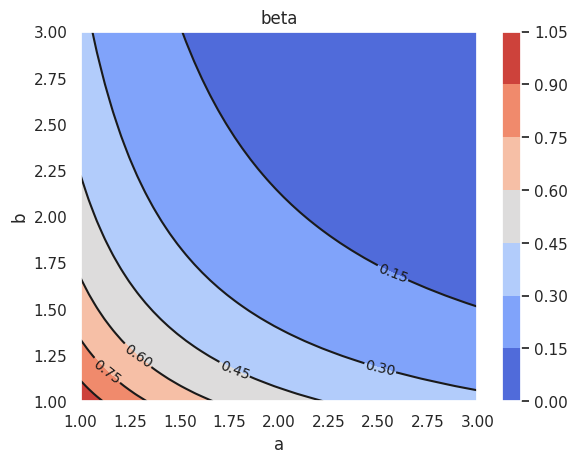

In [20]:
plot_beta_func((1, 3))

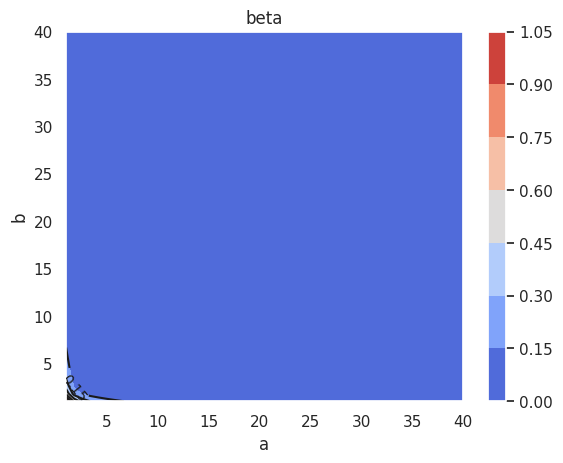

In [21]:
plot_beta_func((1, 40))